Este código implementa o algoritmo AutoCloud, uma abordagem baseada em aprendizado não supervisionado para a detecção de padrões e agrupamento de dados. 
Usando dataset com dados rotulados, para comparação com o primeiro experimento que usa dados não rotulados

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from plotly.subplots import make_subplots
from plotly.offline import plot
import plotly.graph_objects as go
from scipy.spatial import cKDTree  # Para encontrar o centróide mais próximo
from pandas.plotting import parallel_coordinates



In [11]:
class DataCloud:
	N=0 #Conta o número total de nuvens de dados criadas.
	def __init__(self,x): #É chamado quando uma nova instância de DataCloud é criada.
		self.n=1 #Inicializa o n de pontos na nuvem como 1, pois estamos adicionando o primeiro ponto x.
		self.mean=x #Inicializa a média da nuvem como o valor do primeiro ponto x. A média é o centro da nuvem.
		self.variance=0 #Inicializa a variância como 0, pois com apenas um ponto, não há dispersão.
		self.pertinency=1 #Inicializa o grau de pertinência como 1, indicando que o ponto pertence completamente à nuvem.
		DataCloud.N+=1 #Incrementa o contador de nuvens de dados criadas.
	def addDataClaud(self,x):
		self.n=2 #Define o n de pontos na nuvem como 2, assumindo que estamos adicionando um segundo ponto
		self.mean=(self.mean+x)/2 #Atualiza a média da nuvem. A nova média é a média aritmética entre a média anterior e o novo ponto x.
		self.variance=((np.linalg.norm(self.mean-x))**2) #Atualiza a variância da nuvem. A variância é calculada como o quadrado da distância entre a nova média e o novo ponto x.
	def updateDataCloud(self,n,mean,variance): #Este método atualiza os atributos da nuvem de dados com novos valores.
		self.n=n #Atualiza o número de pontos na nuvem.
		self.mean=mean #Atualiza a média da nuvem.
		self.variance=variance #Atualiza a variância da nuvem.


In [12]:
class AutoCloud:
	c= np.array([DataCloud(0)],dtype=DataCloud)
	alfa= np.array([0.0],dtype=float)
	intersection = np.zeros((1,1),dtype=int)
	listIntersection = np.zeros((1),dtype=int)
	matrixIntersection = np.zeros((1,1),dtype=int)
	relevanceList = np.zeros((1),dtype=int)
	k=1
	def __init__(self, m):
		AutoCloud.m = m
		AutoCloud.c= np.array([DataCloud(0)],dtype=DataCloud)
		AutoCloud.alfa= np.array([0.0],dtype=float)
		AutoCloud.intersection = np.zeros((1,1),dtype=int)
		AutoCloud.listIntersection = np.zeros((1),dtype=int)
		AutoCloud.relevanceList = np.zeros((1),dtype=int)
		AutoCloud.matrixIntersection = np.zeros((1,1),dtype=int)
		AutoCloud.classIndex = []
		AutoCloud.k = 1

	def mergeClouds(self):
		i=0
		while(i<len(AutoCloud.listIntersection)-1):
			merge=False
			j=i+1
			while(j<len(AutoCloud.listIntersection)):
				#print("i",i,"j",j,"l",np.size(AutoCloud.listIntersection),"m",np.size(AutoCloud.matrixIntersection),"c",np.size(AutoCloud.c))
				if(AutoCloud.listIntersection[i] == 1 and AutoCloud.listIntersection[j] == 1):
					AutoCloud.matrixIntersection[i,j] = AutoCloud.matrixIntersection[i,j] + 1;
				nI = AutoCloud.c[i].n
				nJ = AutoCloud.c[j].n
				meanI = AutoCloud.c[i].mean
				meanJ = AutoCloud.c[j].mean
				varianceI = AutoCloud.c[i].variance
				varianceJ = AutoCloud.c[j].variance
				nIntersc = AutoCloud.matrixIntersection[i,j]
				if (nIntersc > (nI - nIntersc) or nIntersc > (nJ - nIntersc)):
					print(f'na iteracao {self.k} houve fusao de clouds')
					merge = True
					#update values
					n = nI + nJ - nIntersc
					mean = ((nI * meanI) + (nJ * meanJ))/(nI + nJ)
					variance = ((nI - 1) * varianceI + (nJ - 1) * varianceJ)/(nI + nJ - 2)
					newCloud = DataCloud(mean)
					newCloud.updateDataCloud(n,mean,variance)
					#atualizando lista de interseção
					AutoCloud.listIntersection = np.concatenate((AutoCloud.listIntersection[0 : i], np.array([1]), AutoCloud.listIntersection[i + 1 : j],AutoCloud.listIntersection[j + 1 : np.size(AutoCloud.listIntersection)]),axis=None)
					#atualizando lista de data clouds
					AutoCloud.c = np.concatenate((AutoCloud.c[0 : i ], np.array([newCloud]), AutoCloud.c[i + 1 : j],AutoCloud.c[j + 1 : np.size(AutoCloud.c)]),axis=None)
					#update  intersection matrix
					M0 = AutoCloud.matrixIntersection
					#Remover linhas
					M1=np.concatenate((M0[0 : i , :],np.zeros((1,len(M0))),M0[i + 1 : j, :],M0[j + 1 : len(M0), :]))
					#remover colunas
					M1=np.concatenate((M1[:, 0 : i ],np.zeros((len(M1),1)),M1[:, i+1 : j],M1[:, j+1 : len(M0)]),axis=1)
					#calculando nova coluna
					col = (M0[:, i] + M0[:, j])*(M0[: , i]*M0[:, j] != 0)
					col = np.concatenate((col[0 : j], col[j + 1 : np.size(col)]))
					#calculando nova linha
					lin = (M0[i, :]+M0[j, :])*(M0[i, :]*M0[j, :] != 0)
					lin = np.concatenate((lin[ 0 : j], lin[j + 1 : np.size(lin)]))
					#atualizando coluna
					M1[:,i]=col
					#atualizando linha
					M1[i,:]=lin
					M1[i, i + 1 : j] = M0[i, i + 1 : j] + M0[i + 1 : j, j].T;
					AutoCloud.matrixIntersection = M1
				j += 1
			if(merge):
				i = 0
			else:
				i += 1

	def run(self,X):
		AutoCloud.listIntersection = np.zeros((np.size(AutoCloud.c)),dtype=int)
		if AutoCloud.k==1:
			AutoCloud.c[0]=DataCloud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k==2:
			AutoCloud.c[0].addDataClaud(X)
			AutoCloud.classIndex.append(0)
		elif AutoCloud.k>=3:
			i=0
			createCloud = True
			AutoCloud.alfa = np.zeros((np.size(AutoCloud.c)),dtype=float)
			for data in AutoCloud.c:
				n= data.n +1
				mean = ((n-1)/n)*data.mean + (1/n)*X
				variance = ((n-1)/n)*data.variance +(1/n)*((np.linalg.norm(X-mean))**2)
				if variance == 0:
					eccentricity = 0
				else:
					eccentricity = (1/n)+((mean-X).T.dot(mean-X))/(n*variance)
				typicality = 1 - eccentricity
				norm_eccentricity = eccentricity/2
				norm_typicality = typicality/(AutoCloud.k-2)
				data.eccAn = eccentricity
				#print('tiṕicidade normalizada',norm_typicality)
				if(norm_eccentricity<=(AutoCloud.m**2 +1)/(2*n)):
					#print('dentro do limiar. tipicidade normalizada:',norm_typicality)
					data.updateDataCloud(n,mean,variance)
					AutoCloud.alfa[i] = norm_typicality
					createCloud= False
					AutoCloud.listIntersection[i] = 1
				else:
					AutoCloud.alfa[i] = 0
					AutoCloud.listIntersection[i] = 0
				i+=1
				
			if(createCloud):
				AutoCloud.c = np.append(AutoCloud.c,DataCloud(X))
				AutoCloud.listIntersection = np.insert(AutoCloud.listIntersection,i,1)
				AutoCloud.matrixIntersection = np.pad(AutoCloud.matrixIntersection, ((0,1),(0,1)), 'constant', constant_values=(0))
			self.mergeClouds()
			#print('AutoCloud.alfa:', AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) >0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.sum(AutoCloud.alfa)
			if np.sum(AutoCloud.alfa) == 0:
				AutoCloud.relevanceList = AutoCloud.alfa /np.inf
			classIndex = np.argmax(AutoCloud.relevanceList)
			AutoCloud.classIndex.append(classIndex)


		AutoCloud.k=AutoCloud.k+1


#Carregamento e Pré-processamento de Dados

In [13]:

df = pd.read_csv('dados_rotulados.csv', sep=',') #Selecionar colunas relevantes

# Selecionar colunas relevantes
f1 = df['tcp.len'].values
f2 = df['mqtt.len'].values
f3 = df['tcp.time_delta'].values

#Criar array de dados e transpor
dados = np.array([f1,f2,f3]).T
print(f"Total de amostras no array 'dados': {dados.shape}")

#Definir o número de amostras a serem plotadas
j = 88000  #Altere esse valor para o número desejado de amostras


Total de amostras no array 'dados': (140544, 3)


In [14]:
df.keys()

Index(['frame.time_relative', 'frame.time_epoch', 'frame.time', 'ip.src',
       'ip.dst', 'tcp.stream', 'tcp.seq', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.flags', 'tcp.flags.ack', 'tcp.flags.syn',
       'tcp.flags.fin', 'tcp.flags.urg', 'tcp.time_delta',
       'tcp.window_size_value', 'mqtt.msgtype', 'mqtt.dupflag',
       'mqtt.hdrflags', 'mqtt.len', 'mqtt.msg', 'mqtt.qos', 'mqtt.msgid',
       'time_only', 'label'],
      dtype='object')

In [15]:
# Criar objeto AutoCloud
teste = AutoCloud(1.8) #Parametro m pode ser alterado conforme demanda do dataset.

In [16]:

# Criar dicionário para contar quantas amostras pertencem a cada cloud
contagem_clouds = {}

# Processar apenas as primeiras j amostras
for dado in dados[:j]:
    teste.run(np.array(dado))  # Executa o AutoCloud para cada amostra
    cloud_index = teste.classIndex[-1]  # Obtém o índice da cloud associada à amostra atual
    
    # Incrementar contador para essa cloud
    if cloud_index in contagem_clouds:
        contagem_clouds[cloud_index] += 1
    else:
        contagem_clouds[cloud_index] = 1

print('--------------------------------')

# Exibir informações das clouds e o número de amostras em cada uma
for k, cloud in enumerate(teste.c, start=0):
    num_amostras = contagem_clouds.get(k, 0)  # Pega a contagem ou 0 se a cloud não tiver amostras
    print(f'Cloud número {k+1}')
    print(f'n: {cloud.n}') #n,número total de amostras na cloud.
    print(f'Média: {cloud.mean}') #Média da cloud
    print(f'Variância: {cloud.variance}') #Variância da cloud.
    print(f'Amostras associadas: {num_amostras}') #Quantidade de amostras associadas à cloud durante o processamento.
   


na iteracao 10 houve fusao de clouds
na iteracao 17 houve fusao de clouds
na iteracao 28 houve fusao de clouds
na iteracao 44 houve fusao de clouds
na iteracao 59 houve fusao de clouds
na iteracao 75 houve fusao de clouds
na iteracao 91 houve fusao de clouds
na iteracao 127 houve fusao de clouds
na iteracao 153 houve fusao de clouds
na iteracao 161 houve fusao de clouds
na iteracao 178 houve fusao de clouds
na iteracao 187 houve fusao de clouds
na iteracao 198 houve fusao de clouds
na iteracao 211 houve fusao de clouds
na iteracao 218 houve fusao de clouds
na iteracao 226 houve fusao de clouds
na iteracao 250 houve fusao de clouds
na iteracao 276 houve fusao de clouds
na iteracao 289 houve fusao de clouds
na iteracao 296 houve fusao de clouds
na iteracao 352 houve fusao de clouds
na iteracao 365 houve fusao de clouds
na iteracao 379 houve fusao de clouds
na iteracao 402 houve fusao de clouds
na iteracao 413 houve fusao de clouds
na iteracao 431 houve fusao de clouds
na iteracao 443 hou

/tmp/ipykernel_8953/2247420822.py:9: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



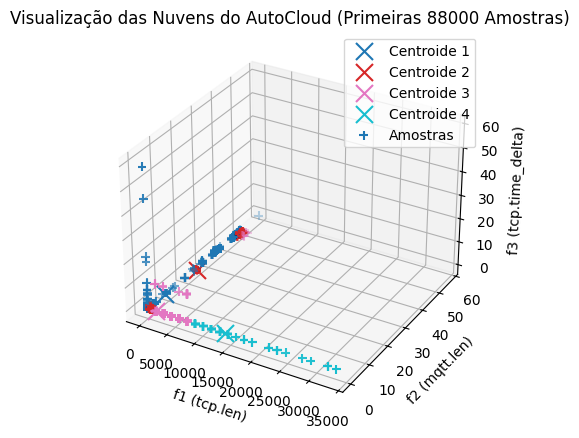

In [17]:

# Criar figura e eixos 3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')     

j = 88000 # Quantidade de amostras usadas

# Gerar cores únicas para cada centróide
num_centroides = len(teste.c)
cores_centroides = plt.cm.get_cmap("tab10", num_centroides)  # Escolher um mapa de cores

# Criar um array para armazenar as cores dos centroides
centroides = np.array([cloud.mean[:3] for cloud in teste.c])  # Pegar apenas as 3 primeiras dimensões
cores = [cores_centroides(i) for i in range(num_centroides)]

# Criar KDTree para encontrar o centróide mais próximo de cada amostra
tree = cKDTree(centroides)
amostras = np.column_stack((f1[:j], f2[:j], f3[:j]))  # Criar matriz com as 3 primeiras features
distancias, indices = tree.query(amostras)  # Encontra o centróide mais próximo

# Plotar os centroides
for i, cloud in enumerate(teste.c):
    m = cloud.mean[:3]  # Usar apenas as 3 primeiras dimensões
    ax.scatter(m[0], m[1], m[2], marker='x', s=150, color=cores[i], label=f'Centroide {i+1}')

# Plotar as amostras com cores correspondentes aos centroides mais próximos
ax.scatter(f1[:j], f2[:j], f3[:j], c=[cores[i] for i in indices], marker='+', s=40, label='Amostras')

# Rótulos dos eixos
ax.set_xlabel('f1 (tcp.len)')
ax.set_ylabel('f2 (mqtt.len)')
ax.set_zlabel('f3 (tcp.time_delta)')

# Título e legenda
ax.set_title(f'Visualização das Nuvens do AutoCloud (Primeiras {j} Amostras)')
ax.legend(loc='upper right')

plt.show()

 #Pairplot com Seaborn

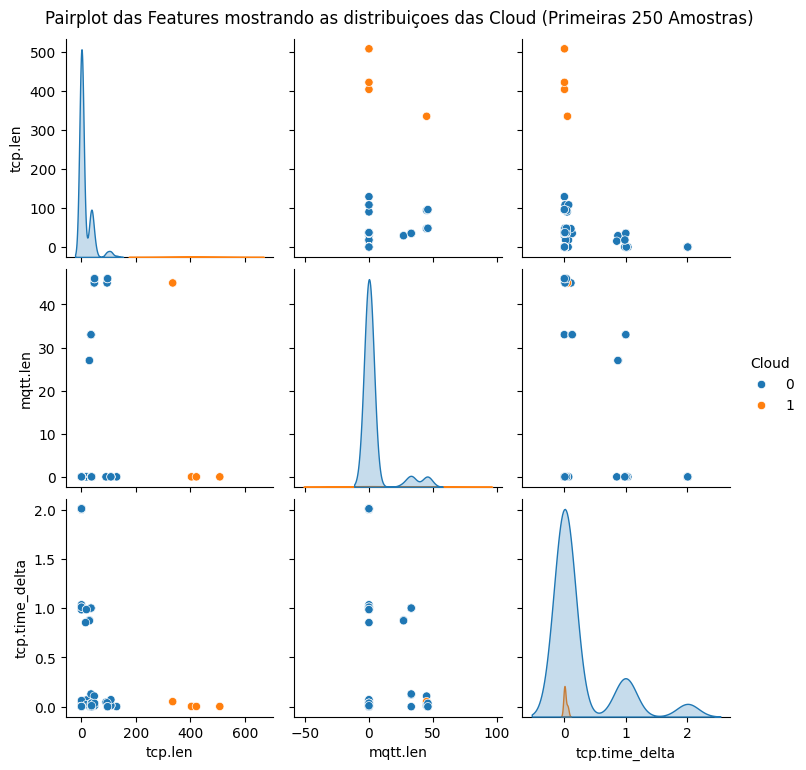

In [18]:
# Definir o número de amostras a serem plotadas
j = 250  # Altere esse valor para o número desejado de amostras

# Criar um DataFrame com as features e os clusters
df_features = pd.DataFrame({
    'tcp.len': f1[:j],
    'mqtt.len': f2[:j],
    'tcp.time_delta': f3[:j],
    'Cloud': indices[:j]  # Usando os índices dos clusters mais próximos
})

# Plotar pairplot
sns.pairplot(df_features, hue='Cloud', palette='tab10', diag_kind='kde')
plt.suptitle(f'Pairplot das Features mostrando as distribuiçoes das Cloud (Primeiras {j} Amostras)', y=1.02)
plt.show()
